In [1]:
import numpy as np
import matplotlib.pyplot as plt; plt.style.use('classic')
import matplotlib.ticker as ticker
import seaborn as sns; sns.set()
import pandas as pd
from mgcpy.independence_tests.mgc.mgc import MGC
from mgcpy.independence_tests.dcorr import DCorr
import math
%matplotlib inline

In [2]:
np.random.seed(88889999)
from graspy.embed import AdjacencySpectralEmbed, select_dimension
from graspy.utils import get_lcc, get_multigraph_intersect_lcc
from graspy.inference import NonparametricTest

from graspy.simulations import sbm, rdpg
from graspy.utils import symmetrize, get_lcc
from graspy.plot import heatmap, pairplot
from scipy.stats import bernoulli
#from mgcpy.hypothesis_tests.transforms import k_sample_transform
from tqdm import tqdm_notebook as tqdm

In [8]:
def get(n=50, graph=False):
    X1 = np.random.uniform(0.2,0.6,n).reshape(-1,1)
    # X2 = np.random.uniform(0.2,0.7,n).reshape(-1,1)
    X2 = np.random.uniform(0.5,0.9,n).reshape(-1,1)
    A1 = rdpg(X1,
          loops=False,
          rescale=False,
          directed=False)
    A2 = rdpg(X2,
          loops=False,
          rescale=False,
          directed=False)
    
    # A1, A2 = get_multigraph_intersect_lcc([A1,A2])
    # A1 = get_lcc(A1)
    # A2 = get_lcc(A2)
    
    if graph:
        return A1, A2
    
    num_dims1 = select_dimension(A1)[0][-1]
    num_dims2 = select_dimension(A2)[0][-1]
    n_components = max(num_dims1, num_dims2)
    
    ase = AdjacencySpectralEmbed(n_components=n_components)
    A1 = ase.fit_transform(A1)
    A2 = ase.fit_transform(A2)
    return A1, A2

In [9]:
def power(indept_test, mc=100, alpha=0.05, fast=True, **kwargs):
    test_stat_null_array = np.zeros(mc)
    test_stat_alt_array = np.zeros(mc)
    for i in range(mc):
        A, B = get(**kwargs)
        X, Y = k_sample_transform(A, B)
        X2 = np.random.permutation(X)
        test_stat_alt_array[i] = indept_test.test_statistic(X, Y, is_fast=fast)[0]
        test_stat_null_array[i] = indept_test.test_statistic(X2, Y, is_fast=fast)[0]

    critical_value = np.sort(test_stat_null_array)[math.ceil((1-alpha)*mc)]
    power = np.where(test_stat_alt_array > critical_value)[0].shape[0] / mc
    return power

def power_graspy(indept_test, mc=100, alpha=0.05, **kwargs):
    test_stat_null_array = np.zeros(mc)
    test_stat_alt_array = np.zeros(mc)
    for i in range(mc):
        A, B = get(graph=True,**kwargs)
        indept_test.fit(A,B)
        test_stat_alt_array[i] = indept_test.sample_T_statistic_
        test_stat_null_array[i] = indept_test.null_distribution_[0]

    critical_value = np.sort(test_stat_null_array)[math.ceil((1-alpha)*mc)]
    power = np.where(test_stat_alt_array > critical_value)[0].shape[0] / mc
    return power

In [10]:
def k_sample_transform(x, y):
    u = np.concatenate([x, y], axis=0)
    v = np.concatenate([np.repeat(1, x.shape[0]), np.repeat(2, y.shape[0])], axis=0)

    if len(u.shape) == 1:
        u = u[..., np.newaxis]
    if len(v.shape) == 1:
        v = v[..., np.newaxis]

    return u, v

In [11]:
def power_calc(test, fast=True, graspy=False):
    pows = []
    x = range(10,101,10)
    for _ in range(5):
        xs = []
        for n in tqdm(x):
            if graspy:
                p = power_graspy(test, n=n)
            else:
                p = power(test, fast=fast, n=n)
            xs.append(p)
        pows.append(xs)
    return pows

In [12]:
mgc = MGC()
pows_mgc = power_calc(mgc)

/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1694: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered i

/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings

/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1694: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1694: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/anaconda3/lib/pyth

/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1694: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1694: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/anaconda3/lib/pyth

/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings

/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings

/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings

/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings

/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings

/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings

/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings

/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1694: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy

/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1694: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy

/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings

/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings

/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings

/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings

/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1694: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy

/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1694: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy

/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1694: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy

/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1694: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy

/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings

/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings

/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings

/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings

/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings

/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1694: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered i

/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1694: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy

/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings

/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings

/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings

/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings

/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings

/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings

/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1694: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1694: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/anaconda3/lib/pyth

/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1694: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy

/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings

/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1694: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy

/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1694: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy

/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings

/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings

/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings

/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings

In [13]:
%matplotlib inline

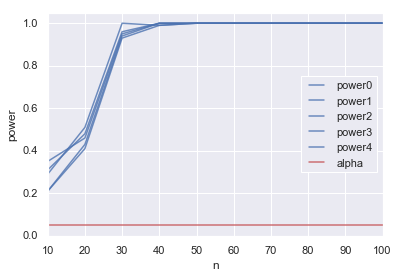

In [14]:
x = range(10,101,10)
for i in range(5):
    plt.plot(x,pows_mgc[i], 'b', alpha=0.8 , label='power'+str(i))
plt.plot(x,[0.05]*len(x),'r',alpha=0.8, label='alpha')
plt.xlabel('n')
plt.ylim([0,1.05])
plt.ylabel('power')
plt.legend(loc='best')

In [ ]:
dcorr = DCorr()
pows_dcorr = power_calc(dcorr, False)

In [ ]:
for i in range(5):
    plt.plot(x,pows_dcorr[i], 'b', alpha=0.8 , label='power'+str(i))
plt.plot(x,[0.05]*len(x),'r',alpha=0.8, label='alpha')
plt.xlabel('n')
plt.ylim([0,1.05])
plt.ylabel('power')
plt.legend(loc='best')

In [ ]:
npt = NonparametricTest(n_bootstraps=1)
pows_npt = power_calc(npt, graspy=True)

In [ ]:
for i in range(5):
    plt.plot(x,pows_npt[i], 'b', alpha=0.8 , label='power'+str(i))
plt.plot(x,[0.05]*len(x),'r',alpha=0.8, label='alpha')
plt.xlabel('n')
plt.ylim([0,1.05])
plt.ylabel('power')
plt.legend(loc='best')

In [ ]:
for i in range(1): #5
    plt.plot(x,pows_npt[i], 'b', alpha=0.8 , label='power_biased_mmd')
    plt.plot(x,pows_dcorr[i], 'r', alpha=0.8 , label='power_unbiased_mmd')
    plt.plot(x,pows_mgc[i], 'g', alpha=0.8 , label='power_unbiased_mgc')

plt.plot(x,[0.05]*len(x),'r',alpha=0.8, label='alpha')
plt.xlabel('n')
plt.ylim([0,1.05])
plt.ylabel('power')
plt.legend(loc='best')